## GRAPPA Student Seminar 2019
# Week 2 - Script
### by *The Sterile Neutrinos* group

In [1]:
import numpy as np
from astropy import constants as C
from astropy import units
# Tell astropy that E=mc^2, and c=1
units.set_enabled_equivalencies([
    (units.kg, units.J, lambda x: x*C.c.value**2, lambda x: x/C.c.value**2),
    (units.s, units.m, lambda x: x*C.c.value, lambda x: x/C.c.value)
])
from matplotlib_import import *

### Part 1. Upper limits

Define the various constants with proper units:

In [2]:
N_A = C.N_A * units.mol / units.g  # [#/mass]

rho = (0.3 * units.GeV/units.cm**3).decompose()
v_0 = 220 * units.km/units.s
v_avg = (2/np.sqrt(np.pi)) * v_0

M = 500 * units.kg
T = 1 * units.yr
A = 131.293  # xenon
m_N = A * units.u
E_Rm = 3 * units.keV

and the various formulae:

In [3]:
def mu(mx):
    return mx*C.m_p / (mx + C.m_p)

def r(mx):
    return 4 * mx*m_N / (mx+m_N)**2

def E_0(mx):
    return 0.5*mx*v_0**2

def exp_factor(mx, E):
    return np.exp(- E / (r(mx) * E_0(mx)))

def R_0_over_sigma(mx):
    return (N_A * rho * A * v_avg / C.m_p ** 2) * (mu(mx) ** 2 / mx)

def sigma(mx, R):
    return (R / exp_factor(mx, E_Rm)) / R_0_over_sigma(mx)

When calculating the expected number of events, we need to integrate the distribution $\text{d}R / \text{d}E_R$ only over energies greater than the threshold $E_{R, \text{min}}$, and so
$$R = \int_{E_{R, \text{min}}}^{\infty} \frac{\text{d}R}{\text{d}E_R} \text{d}E_R = \int_{E_{R, \text{min}}}^{\infty} R_0 \text{e}^{-\frac{E_R}{r E_0}} = R_0 \text{e}^{-\frac{E_{R, \text{min}}}{r E_0}}.$$

We will calculate the upper bound on $\sigma$ by supposing that we in fact detected $3$ (three) events in a year in $500\ \text{kg}$ of xenon because nature had it that $\ln{20} \approx 3$. We will do it for a range of dark matter masses appropriate for stndard WIMPs. (We also define an array of possible cross-sections for later use.)

In [4]:
mxs_edges = np.logspace(np.log10(6), 3, 1001) * units.GeV
sigmas_edges = np.logspace(-40, -44, 1001) * units.cm**2

mxs = (mxs_edges[1:] + mxs_edges[:-1]) / 2
sigmas = (sigmas_edges[1:] + sigmas_edges[:-1]) / 2

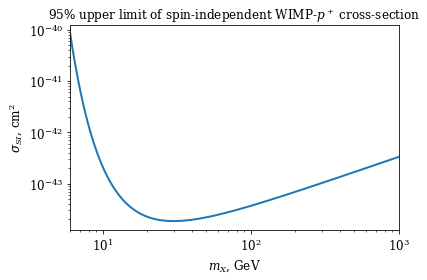

In [5]:
plt.loglog(mxs, sigma(mxs, 3 / T / M).to(sigmas.unit))
plt.xlabel(r'$m_X$, {:latex_inline}'.format(mxs.unit))
plt.ylabel(r'$\sigma_{{SI}}$, {:latex_inline}'.format(sigmas.unit))
plt.xlim(mxs_edges[0].value, mxs_edges[-1].value)
plt.title('$95\%$ upper limit of spin-independent WIMP-$p^+$ cross-section')
plt.tight_layout()

This upper limit is qualitatively similar to [the one presented by the XENON1T experiment](http://inspirehep.net/record/1675772?ln=en) but is two order of magnitude higher, partly due to the smaller assumed volume in our case, but mainly due to their more sophisticated modelling (e.g. they account for the boost caused by the Earth moving through the DM halo).

### Part 2. Houston, we have detection

Next we assume $10$ detected events in the range $[3; 10]\ \text{keV}$ and $5$ in $[10; 20]\ \text{keV}$. The expected number of events is given by the same integral but now with two definite bounds $E_{R, \text{min}}$ and $E_{R, \text{max}}$, which results in
$$R((E_{R, \text{min}}, E_{R, \text{max}}), m_X, \sigma_{SI}) = R_0(m_X, \sigma_{SI}) \left[\text{e}^{-\frac{E_{R, \text{min}}}{r(m_X) E_0(m_X)}} - \text{e}^{-\frac{E_{R, \text{max}}}{r(m_X) E_0(m_X)}}\right],$$
so $R$ is a model with $(E_{R, \text{min}}, E_{R, \text{max}})$ as the independent variable and $m_X$ and $\sigma_{SI}$ as the parameters. Due to Poisson statistics we construct a $\chi^2$ to be minimused as follows:
$$\chi^2 = \sum\limits_{\text{data}} \frac{\left(R_{\text{observed}} - R_{\text{model}}\right)^2}{R_{\text{model}}}$$
and evaluate it on the grid of `mxs` and `sigmas`.

In [36]:
def R_model(E_bounds, mx, sigma):
    return R_0_over_sigma(mx) * sigma * (exp_factor(mx, E_bounds[0]) - exp_factor(mx, E_bounds[1])) * M * T

def chi2(E_bounds, R, mx, sigma):
    mx_nou, sigma_nou = np.broadcast_arrays(mx, sigma)
    mx = mx_nou*mx.unit
    sigma = sigma_nou*sigma.unit

    E_bounds = E_bounds.reshape(list(E_bounds.shape) + [1]*len(mx.shape))
    R = R.reshape(list(R.shape) + [1]*len(mx.shape))

    mu = R_model(E_bounds , mx[None, ...], sigma[None, ...])

    return ((R - mu)**2 / mu).sum(axis=0)

In [37]:
E_bounds = np.array(((3, 10), (10, 20))) * units.keV
R = np.array((10, 5))

c2 = chi2(E_bounds, R, mxs[None, :], sigmas[:, None]).to('')
sigma0i, mx0i = np.unravel_index(np.argmin(c2), c2.shape)
mx0, sigma0 = mxs[mx0i], sigmas[sigma0i]

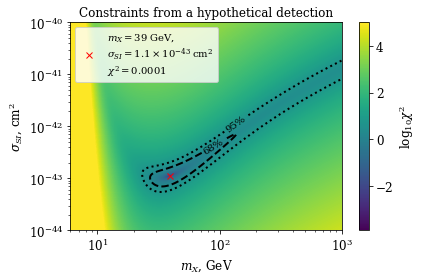

In [38]:
pcm = plt.pcolormesh(mxs_edges, sigmas_edges, np.log10(c2), vmax=5)
con = plt.contour(mxs, sigmas, c2, (2.28, 6),
                  colors='k', linestyles=('--', ':'))
plt.loglog(mx0, sigma0, 'rx',
           label='$m_X = {0.value:.0f}$ {0.unit:latex_inline},'.format(mx0)
                 +'\n$\\sigma_{{SI}} = {}$'.format(sigma0.to_string(format='latex', precision=2).replace('$', ''))
                 +'\n$\\chi^2 = {}$'.format(c2[sigma0i, mx0i].to_string(format='latex', precision=1).replace('$', '')))

cax = plt.colorbar(pcm)
cax.set_label(r'$\log_{10}\chi^2$')
plt.xlabel(r'$m_X$, {:latex_inline}'.format(mxs.unit))
plt.ylabel(r'$\sigma_{{SI}}$, {:latex_inline}'.format(sigmas.unit))
plt.legend(loc='upper left')
plt.clabel(con, con.levels, fmt={2.28: '68%', 6: '95%'})
plt.title('Constraints from a hypothetical detection')
plt.tight_layout()